# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Описание данных**
* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [85]:
# Импортируем библиотеку pandas, запишем содержимое файла csv в датафрейм df

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
df = pd.read_csv('/datasets/data.csv')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

* Имеем датафрейм из 21525 строк и 12 колонок. 
* Типы данных: 2 колонки - вещественный, 5 - целочисленный, 5 - строковый. 
* В колонках days_employed и total_income количество строк меньше, значит там будем искать пропуски. 
* Названия колонок в целом соответствуют правилам, хотя колонку с возрастом dob_years лучше переименовать в age, debt  - в debt_status, days_employed - employed. Видим, что в этой колонке присутствуют аномалии в виде отрицательных значений, наличия знаков после точки и слишком высоких значений. 
* Данные общего ежемесячного дохода в total_income следует также округлить. 
* Колонки education и family_status лучше вынести в отдельные таблицы и убрать из основного датафрейма.

## Шаг 2. Предобработка данных

### Общая обработка 

#### Переименуем колонки датафрейма

In [3]:
df.set_axis(['children', 'employed', 'age', 'education', 'education_id', 'family_status', 
             'family_status_id', 'gender', 'income_type', 'debt_status', 'total_income', 'purpose'], axis=1, inplace=True)
df.columns.to_frame()

,0
children,children
employed,employed
age,age
education,education
education_id,education_id
family_status,family_status
family_status_id,family_status_id
gender,gender
income_type,income_type
debt_status,debt_status


### Обработка пропусков

#### Исследуем аномалии во всех колонках и пропуски в колонках employed и total_income
##### Колонка children

In [4]:
# Частотное разложение уникальных значений в колонке children

df['children'].value_counts().to_frame() 

,children
0,14149
1,4818
2,2055
3,330
20,76
-1,47
4,41
5,9


Обращаем внимание на аномальные значения количества детей в семье: "-1" и "20". 

Так как эта метрика имеет ключевое значение для целей исселедования, ошибочные выбросы в ней могут серьезно на него повлиять. Значения "20" нужно заменить на "2", а "-1" на "1", либо все ошибки заменить на медианное значение "0". Третий вариант: целиком убрать строки с ошибочными данными, так как ошибка имеет случайный характер и составляет 123 / 21 525 * 100% = 0,6%, следовательно удаление данных не повлияет на исследование и данными можно пренебречь. Склоняюсь к первому варианту. 

In [5]:
# Первый вариант с заменой

df.loc[df['children'] == 20, 'children'] = 2
df.loc[df['children'] == -1, 'children'] = 1
df['children'].value_counts().to_frame()

# Третий вариант с удалением

#df = df.loc[df['children'] != 20]
#df = df.loc[df['children'] != -1]
#df['children'].value_counts()

,children
0,14149
1,4865
2,2131
3,330
4,41
5,9


##### Колонка age

In [6]:
# Уникальные значения в колонке с возрастом age

df['age'].unique() 

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

Есть аномальное значение 0, что предположительно является пропуском

In [7]:
df['age'].value_counts().tail(10).to_frame()

,age
68,99
69,85
70,65
71,58
20,51
72,33
19,14
73,8
74,6
75,1


Возраст "0" присутствует 101 раз. Заменим его на медианное значение в зависимости от группы занятости 'income_type'

In [8]:
income_type_group = df.groupby('income_type')['age'].median().astype('int')
income_type_group

income_type
безработный        38
в декрете          39
госслужащий        40
компаньон          39
пенсионер          60
предприниматель    42
сотрудник          39
студент            22
Name: age, dtype: int64

In [9]:
income_type_group.index

Index(['безработный', 'в декрете', 'госслужащий', 'компаньон', 'пенсионер',
       'предприниматель', 'сотрудник', 'студент'],
      dtype='object', name='income_type')

Заменим значения возраста в каждой группе

In [11]:
i = 0

for income in income_type_group.index:
    df.loc[(df['income_type'] == income) & (df['age'] == 0), 'age'] = income_type_group[i]
    i += 1  

In [12]:
df[df['age'] == 0]['age'].count()

0

In [13]:
# Убедимся, что замена прошла успешно

df['age'].value_counts().tail(10).to_frame()

,age
68,99
69,85
70,65
71,58
20,51
72,33
19,14
73,8
74,6
75,1


##### Колонка employed

In [14]:
# Исследуем на пропуски колонку employed

df['employed'].isnull().sum() 

2174

In [15]:
df['employed'].isnull().sum() / df['employed'].count()

0.11234561521368405

Пропуски составляют 11% от всех данных, что довольно существенно

In [16]:
# Подсчет уникальных значений в колонке employed

df.groupby('employed')['employed'].count()

employed
-18388.949901     1
-17615.563266     1
-16593.472817     1
-16264.699501     1
-16119.687737     1
                 ..
 401663.850046    1
 401674.466633    1
 401675.093434    1
 401715.811749    1
 401755.400475    1
Name: employed, Length: 19351, dtype: int64

Довольно странный диапазон значений для трудового стажа в днях: от -18 388 до 401 755. Количество рабочих дней трудового стажа 100-летнего человека при 247 рабочих днях в году в среднем не может превышать: (100 - 16) х 247 ~ 21 000 дней. Можно видеть, что отрицательные числа логически укладываются в разумные пределы трудового стажа, если отбросить знак и округлить до целого. А вот положительные значения видимо выражены в часах, что легко проверить, разделив максимальное положительное число на 24: 401 755 : 24 = 16 739 дней.  

Разобъем данные на положительные и отрицательные числа. У первых отбросим знак, вторые разделим на 24. 

In [17]:
# Напишем функцию для обработки колонки employed

def employed_processing(emp):
    if emp <= 0:
        return abs(emp)
    else:
        return emp / 24
    
# Применим функцию

df['employed'] = df['employed'].apply(employed_processing)
df['employed'].value_counts()

8437.673028     1
3507.818775     1
14770.850661    1
769.717438      1
3963.590317     1
               ..
1099.957609     1
209.984794      1
16587.474685    1
1271.038880     1
1984.507589     1
Name: employed, Length: 19351, dtype: int64

Заменим пропуски методом fillna() на медианные значения в зависимости от возраста. 
Медиану для каждой группы получим методом median()

In [18]:
df['age'].describe().to_frame()

,age
count,21525.000000
mean,43.496167
std,12.231538
min,19.000000
25%,34.000000
50%,43.000000
75%,53.000000
max,75.000000


Для этого разобьем стаж на 4 группы по перценталям распределения возраста и добавим в датафрейм столбец-идентификатор группы age_id:

    1: 19-34
    2: 35-43
    3: 44-53
    4: 54-75

In [19]:
# Составим функцию для распределения значений 

def get_age_id(row):
    age = row['age']
    if age <= 34:
        return 1
    elif 35 <= age <= 43:
        return 2
    elif 44 <= age <= 53:
        return 3
    elif 54 <= age <= 75:
        return 4

In [20]:
# Вносим данные в новый столбец

df['age_id'] = df.apply(get_age_id, axis=1)
df[['age', 'age_id']].head(10)

,age,age_id
0,42,2
1,36,2
2,33,1
3,32,1
4,53,3
5,27,1
6,43,2
7,50,3
8,35,2
9,41,2


In [21]:
# Временно присвоим пропускам нулевые значения для удобства   

df['employed'] = df['employed'].fillna(0)
df['employed'].value_counts()

0.000000        2174
8437.673028        1
5135.928528        1
14770.850661       1
769.717438         1
                ... 
1099.957609        1
209.984794         1
16587.474685       1
1271.038880        1
1984.507589        1
Name: employed, Length: 19352, dtype: int64

In [22]:
# Находим медианы для каждой группы

age_id_group = df.groupby('age_id')['employed'].median()
age_id_group

age_id
1     1031.782464
2     1576.393455
3     2105.631868
4    14048.556619
Name: employed, dtype: float64

In [23]:
# Заполняем колонку стажа медианными значениями в зависимости от группы

df.loc[(df['age_id'] == 1) & (df['employed'] == 0), 'employed'] = age_id_group[1]
df.loc[(df['age_id'] == 2) & (df['employed'] == 0), 'employed'] = age_id_group[2]
df.loc[(df['age_id'] == 3) & (df['employed'] == 0), 'employed'] = age_id_group[3]
df.loc[(df['age_id'] == 4) & (df['employed'] == 0), 'employed'] = age_id_group[4]

In [24]:
# Проверяем наличие нулевых значений для столбца стажа

df[df['employed'] == 0]['employed'].count()

0

##### Колонка education

In [25]:
# Уникальные значения в колонке education

df['education'].value_counts().to_frame() 

# Есть явные повторы. Составим словарь и уберем эту колонку из датафрейма

,education
среднее,13750
высшее,4718
СРЕДНЕЕ,772
Среднее,711
неоконченное высшее,668
ВЫСШЕЕ,274
Высшее,268
начальное,250
Неоконченное высшее,47
НЕОКОНЧЕННОЕ ВЫСШЕЕ,29


##### Колонка education_id

In [26]:
# Уникальные значения в колонке education_id

df['education_id'].unique()

# нет аномалий и повторов

array([0, 1, 2, 3, 4])

##### Колонка family_status

In [27]:
# Уникальные значения в колонке family_status

df['family_status'].unique() 

# нет аномалий и повторов

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

##### Колонка family_status_id

In [28]:
# уникальные значения в колонке family_status_id

df['family_status_id'].unique() 

# нет аномалий и повторов

array([0, 1, 2, 3, 4])

##### Колонка gender

In [29]:
# уникальные значения в колонке gender

df['gender'].unique() 

# здесь есть неявные пропуски

array(['F', 'M', 'XNA'], dtype=object)

In [30]:
df['gender'].value_counts() 

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [31]:
df[df['gender'] == 'XNA']

,children,employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt_status,total_income,purpose,age_id
10701,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости,1


Пропуск всего 1, его можно устранить внесением значения моды пола

In [32]:
# Присвоим пропуску модное значение "F" и убедимся в замене

df.loc[df['gender'] == 'XNA', 'gender'] = 'F'
df['gender'].value_counts().to_frame() 

,gender
F,14237
M,7288


##### Колонка income_type

In [33]:
# уникальные значения в колонке income_type

df['income_type'].unique() 

# здесь нет аномалий и повторов

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

##### Колонка debt_status

In [34]:
# уникальные значения в колонке debt_status

df['debt_status'].unique() 

# здесь нет аномалий и повторов

array([0, 1])

##### Колонка total_income

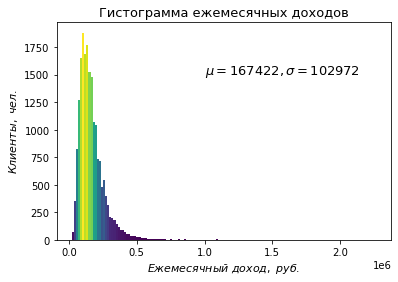

count      19351.0
mean      167422.0
std       102972.0
min        20667.0
25%       103053.0
50%       145018.0
75%       203435.0
max      2265604.0
Name: total_income, dtype: float64


In [96]:
ax1 = plt.hist(df['total_income'], bins=int(np.sqrt(len(df))))

# N — счетчик в каждом баре (столбце), bins — нижняя граница бара
N, bins, patches = plt.hist(df['total_income'], bins=int(np.sqrt(len(df))))
                               
# Для кодирования цвета будем использовать относительную высоту
fracs = N / N.max()

# нормализуем fracs до промежутка между 0 и 1 для полноценного цветового диапазона
norm = colors.Normalize(fracs.min(), fracs.max())

# нужно пройтись циклом по полученным объектам и установить цвет для каждого в отдельности
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

ax1 = plt.xlabel('$Ежемесячный$ $доход,$ $руб.$', fontsize=11)
ax1 = plt.ylabel('$Клиенты,$ $чел.$', fontsize=11)
plt.title('Гистограмма ежемесячных доходов', fontsize=13)
plt.text(1000000, 1500, '$\mu=167422,\sigma=102972$', fontsize=13)
plt.show()
print(round(df['total_income'].describe()))

In [35]:
# Исследуем на пропуски колонку total_income

df['total_income'].isna().sum() 

# Есть пропуски, и их количество совпало с данными в колонке employed

2174

In [36]:
df.groupby('total_income')['total_income'].count()

# Как и количество уникальных значений: 19351

total_income
2.066726e+04    1
2.120528e+04    1
2.136765e+04    1
2.169510e+04    1
2.189561e+04    1
               ..
1.711309e+06    1
1.715018e+06    1
1.726276e+06    1
2.200852e+06    1
2.265604e+06    1
Name: total_income, Length: 19351, dtype: int64

Заменим временно пропуски на нули

In [37]:
# Найдем медианы дохода для каждой группы занятости

total_income_group = df.groupby('income_type')['total_income'].median()
total_income_group.to_frame()

,total_income
income_type,
безработный,131339.751676
в декрете,53829.130729
госслужащий,150447.935283
компаньон,172357.950966
пенсионер,118514.486412
предприниматель,499163.144947
сотрудник,142594.396847
студент,98201.625314


In [38]:
# Попробуем сделать более узкую выборку. Найдем медианы дохода для каждому типу занятости, образования и возрастной группе  

total_income_group_3 = df.groupby(['income_type', 'age_id', 'education_id'])['total_income'].median()
total_income_group_3.tail(15).to_frame()

total_income
income_type age_id education_id               
сотрудник   2      1             140108.105563
                   2             162204.016314
                   3             124294.504244
                   4             115949.039788
            3      0             169412.945538
                   1             136588.000855
                   2             167686.286724
                   3             130600.077985
                   4             198570.757322
            4      0             174775.300640
                   1             136885.746787
                   2             177913.652679
                   3             146009.429326
                   4             268411.214536
студент     1      0              98201.625314

In [39]:
total_income_group_3.isna().sum()

1

Для одной группы не нашлось ни одного значения для расчета медианы, поэтому в этом случае расширим группировку

In [40]:
total_income_group_1 = df.groupby(['income_type', 'age'])['total_income'].median()
total_income_group_1.isna().sum()

4

In [41]:
total_income_group_2 = df.groupby(['income_type', 'education_id'])['total_income'].median()
total_income_group_2.tail(10).to_frame()

total_income
income_type     education_id               
пенсионер       2             120136.896353
                3             102598.653164
                4             177088.845999
предприниматель 0             499163.144947
сотрудник       0             165640.744634
                1             136555.108821
                2             151308.937846
                3             125994.910603
                4             198570.757322
студент         0              98201.625314

In [42]:
total_income_group_2.isna().sum()

0

Заменяем пропуски в столбце дохода медианными значениями в зависимости от группы занятости

In [45]:
# Проверяем наличие пропусков

df.total_income.isna().sum()

1

In [46]:
df[df['total_income'].isna()]

,children,employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt_status,total_income,purpose,age_id
5936,0,14048.556619,58,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости,4


Значение для предпринимателя в необработанной единственной строке возьмем из total_income_group_2

In [47]:
df['total_income'] = df.groupby(['income_type', 'education_id'])['total_income'].transform(lambda x: x.fillna(x.mean()))

In [48]:
df.total_income.isna().sum()

0

##### Колонка purpose

In [49]:
# Исследуем на пропуски колонку purpose

df['purpose'].unique() 

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

**В колонке purpose нужно отобрать неявные повторы с помощью лемматизатора**

#### Колонки education и family_status вынесем в отдельные таблицы-словари и уберем как избыточные из основного датафрейма

In [50]:
df_education = df.loc[:, ['education', 'education_id']]
df_education.head(10)

,education,education_id
0,высшее,0
1,среднее,1
2,Среднее,1
3,среднее,1
4,среднее,1
5,высшее,0
6,высшее,0
7,СРЕДНЕЕ,1
8,ВЫСШЕЕ,0
9,среднее,1


Уберем явные и неявные повторы с помощью методов str.lower() и drop_duplicates()

In [51]:
df_education['education'] = df_education['education'].str.lower()
df_education = df_education.drop_duplicates().reset_index(drop=True)
df_education

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


In [52]:
df_family_status = df.loc[:, ['family_status', 'family_status_id']]
df_family_status = df_family_status.drop_duplicates().reset_index(drop=True)
df_family_status

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


Поправим регистр в последней категории

In [53]:
df_family_status.loc[4, 'family_status'] = 'не женат / не замужем'
df_family_status

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,не женат / не замужем,4


Теперь уберем лишние столбцы из датафрейма

In [54]:
df = df.drop(columns=['education', 'family_status'])

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   employed          21525 non-null  float64
 2   age               21525 non-null  int64  
 3   education_id      21525 non-null  int64  
 4   family_status_id  21525 non-null  int64  
 5   gender            21525 non-null  object 
 6   income_type       21525 non-null  object 
 7   debt_status       21525 non-null  int64  
 8   total_income      21525 non-null  float64
 9   purpose           21525 non-null  object 
 10  age_id            21525 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 1.8+ MB


**Вывод**

* Для удобства столбцы были переименованы, а лишние перенесены в отдельные таблицы.

* Был проведен анализ данных на предмет пропусков и аномалий. 

* Убрали данные, где количеством детей было аномальным, так как эти значения составляли лишь 0,6% от общих данных и могли существенно повлиять на результат.

* В столбце возраста пропуски в виде нулевого значения заменили на медианное.

* В столбце пола 1 пропуск заменили на значение моды.

* В двух столбцах employed и total_income с вещественным типом данных выявлены одновременные пропуски, которые составляют около 10% от общего количества, что довольно существенно. Заменили пропуски на медианные значения.

* Замечены повторы категорий в столбцах purpose и education.

**Пропусков больше нет**

### Замена типа данных
#### Проведем замену типа данных в колонках employed и total_income на целочисленный

In [56]:
df['employed'] = df['employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')
df.head()

,children,employed,age,education_id,family_status_id,gender,income_type,debt_status,total_income,purpose,age_id
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,2
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,2
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,1
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,1
4,0,14177,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,3


In [57]:
df.dtypes.to_frame()

,0
children,int64
employed,int64
age,int64
education_id,int64
family_status_id,int64
gender,object
income_type,object
debt_status,int64
total_income,int64
purpose,object


**Вывод**

Провели изменения типа данных методом `astype()`, так как он подходит для преобразования типа данных из вещественного в целочисленный. Видим, что в датафрейме данных с вещественными числами больше нет и количественные данные округлены, так как нам нужна только целая часть. Остались целочисленные и строковые данные.

### Обработка дубликатов

#### Найдем явные дубликаты

In [58]:
df.duplicated().sum()

71

In [59]:
df['total_income'].value_counts().head(10)

130499    294
146158    254
156478    247
153459    209
157728    110
184724    100
179770     92
184897     81
169151     80
219868     71
Name: total_income, dtype: int64

Избавляемся от полных дубликатов в датафрейме и обновляем сквозную индексацию

In [60]:
df.drop_duplicates().reset_index(drop=True)

,children,employed,age,education_id,family_status_id,gender,income_type,debt_status,total_income,purpose,age_id
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,2
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,2
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,1
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,1
4,0,14177,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,3
...,...,...,...,...,...,...,...,...,...,...,...
21449,1,4529,43,1,1,F,компаньон,0,224791,операции с жильем,2
21450,0,14330,67,1,0,F,пенсионер,0,155999,сделка с автомобилем,4
21451,1,2113,38,1,1,M,сотрудник,1,89672,недвижимость,2
21452,3,3112,38,1,0,M,сотрудник,1,244093,на покупку своего автомобиля,2


**Вывод**

Для поиска дубликатов использован метод `duplicated()` вместе с `sum()` для отображения их количества. 
Для избавления от дубликатов использован метод `drop_duplicates()` вместе с методом `reset_index()` и аргументом `drop=True` для сброса индексации. Таким образом сделана копия датафрейма без дубликатов.
Возможные причины появления дубликатов в данных заключаются в системной технической ошибке. Причины дубликатов в категориях столбца об образовании - человеческий фактор.

### Лемматизация

Для разбиения на классы выделяем леммы в значениях столбца с целями получения кредита

In [106]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [124]:
# Сделаем из списка запросов строку

queries = ' '.join(df['purpose'])
text = ' '.join(df['purpose'].unique())
queries[:1000]

'покупка жилья приобретение автомобиля покупка жилья дополнительное образование сыграть свадьбу покупка жилья операции с жильем образование на проведение свадьбы покупка жилья для семьи покупка недвижимости покупка коммерческой недвижимости сыграть свадьбу приобретение автомобиля покупка жилой недвижимости строительство собственной недвижимости недвижимость строительство недвижимости на покупку подержанного автомобиля на покупку своего автомобиля недвижимость приобретение автомобиля на покупку подержанного автомобиля сыграть свадьбу операции с коммерческой недвижимостью покупка недвижимости образование строительство собственной недвижимости строительство собственной недвижимости строительство жилой недвижимости операции с коммерческой недвижимостью жилье на проведение свадьбы покупка жилья операции со своей недвижимостью на проведение свадьбы автомобили приобретение автомобиля образование заняться образованием покупка недвижимости сделка с подержанным автомобилем получение образования 

In [ ]:
# Проводим лемматизацию строки, предварительно загрузим модуль лемматизатора 
import json
#pprint(json.dumps(m.analyze(text), ensure_ascii=False))
lemmas = m.lemmatize(queries)
from pprint import pprint

In [211]:
from pymystem3 import Mystem
m = Mystem(entire_input=False)

queries = ' '.join(df['purpose'])
table_analyze = pd.DataFrame(m.analyze(queries))

dict, i = {}, 0

for row in table_analyze['analysis']:
    dict[i] = row[0]
    i += 1

table = pd.DataFrame(dict).transpose()
table.head(10)

,lex,wt,gr
0,покупка,1,"S,жен,неод=им,ед"
1,жилье,1,"S,ед,сред,неод=род"
2,приобретение,1,"S,сред,неод=(вин,ед|им,ед)"
3,автомобиль,1,"S,муж,неод=род,ед"
4,покупка,1,"S,жен,неод=им,ед"
5,жилье,1,"S,ед,сред,неод=род"
6,дополнительный,1,"A=(вин,ед,полн,сред|им,ед,полн,сред)"
7,образование,1,"S,сред,неод=(вин,ед|им,ед)"
8,сыграть,1,"V,сов,пе=инф"
9,свадьба,1,"S,жен,неод=вин,ед"


In [205]:
table[table['gr'].str.contains('S')].groupby('lex')['wt'].count().sort_values(ascending=False)

lex
недвижимость     6367
покупка          5912
жилье            4473
автомобиль       4315
образование      4022
операция         2610
свадьба          2348
строительство    1881
получение        1316
сделка            944
проведение        777
сдача             653
семья             641
ремонт            612
приобретение      462
Name: wt, dtype: int64

In [117]:
# Для подсчета частоты лемм используем функцию Counter из модуля collections 

from collections import Counter
lemmas_count = Counter(lemmas)
sorted(lemmas_count.items(), key = lambda x: x[1], reverse=True)

[('недвижимость', 6367),
 ('покупка', 5912),
 ('жилье', 4473),
 ('автомобиль', 4315),
 ('образование', 4022),
 ('с', 2924),
 ('операция', 2610),
 ('свадьба', 2348),
 ('свой', 2235),
 ('на', 2233),
 ('строительство', 1881),
 ('высокий', 1375),
 ('получение', 1316),
 ('коммерческий', 1315),
 ('для', 1294),
 ('жилой', 1233),
 ('сделка', 944),
 ('дополнительный', 909),
 ('заниматься', 908),
 ('подержать', 858),
 ('проведение', 777),
 ('сыграть', 774),
 ('сдача', 653),
 ('семья', 641),
 ('собственный', 635),
 ('со', 630),
 ('ремонт', 612),
 ('приобретение', 462),
 ('профильный', 436),
 ('подержанный', 110)]

In [86]:
final_list_of_purposes = [i for i in sorted(lemmas_count, key=lemmas_count.get, reverse=True)
                          if len(i) > 4 if i != ' ' if i != '\n'][0:8]
print(final_list_of_purposes)

['недвижимость', 'покупка', 'жилье', 'автомобиль', 'образование', 'операция', 'свадьба', 'строительство']


**Вывод**

Выделены леммы в значениях столбца с целями получения кредита. 

Выделяем следующие 6 категорий целей на основе анализа лемм: 

1. строительство или ремонт
2. автомобиль
3. образование
4. свадьба
5. недвижимость или жилье 
6. другое

Слово "покупка" слишкое общее и емкое, слово "операция" здесь относится только к недвижимости.

Процесс лемматизации:
* Получение уникальных значений столбца методом unique()
* Сведение значений в строку методом join()
* Лемматизация строки методом lemmatize() из модуля Mystem библиотеки pymystem3 Яндекса
* Нахождение частот лемм для классификации

### Категоризация данных

#### Проведем категоризацию клиентов в зависимости от категории цели кредита 

Введем функцию, возвращающую идентификатор категории цели кредита в зависимости от лемм цели

In [65]:
def get_purpose_id(purposes):
    
    # извлекаем леммы из запроса  
    lemma = m.lemmatize(purposes)
    
    if (('строительство' in lemma) or ('ремонт' in lemma)):
        return 0
    elif 'автомобиль' in lemma:
        return 1
    elif 'образование' in lemma:
        return 2
    elif 'свадьба' in lemma:
        return 3
    elif (('недвижимость' in lemma) or ('жилье' in lemma)):
        return 4
    else:
        return 5

In [66]:
# Составим словарь категорий целей

purpose_dict = {}

for key in df['purpose'].unique():
    purpose_dict[key] = get_purpose_id(key)
    
purpose_dict

{'покупка жилья': 4,
 'приобретение автомобиля': 1,
 'дополнительное образование': 2,
 'сыграть свадьбу': 3,
 'операции с жильем': 4,
 'образование': 2,
 'на проведение свадьбы': 3,
 'покупка жилья для семьи': 4,
 'покупка недвижимости': 4,
 'покупка коммерческой недвижимости': 4,
 'покупка жилой недвижимости': 4,
 'строительство собственной недвижимости': 0,
 'недвижимость': 4,
 'строительство недвижимости': 0,
 'на покупку подержанного автомобиля': 1,
 'на покупку своего автомобиля': 1,
 'операции с коммерческой недвижимостью': 4,
 'строительство жилой недвижимости': 0,
 'жилье': 4,
 'операции со своей недвижимостью': 4,
 'автомобили': 1,
 'заняться образованием': 2,
 'сделка с подержанным автомобилем': 1,
 'получение образования': 2,
 'автомобиль': 1,
 'свадьба': 3,
 'получение дополнительного образования': 2,
 'покупка своего жилья': 4,
 'операции с недвижимостью': 4,
 'получение высшего образования': 2,
 'свой автомобиль': 1,
 'сделка с автомобилем': 1,
 'профильное образование': 

In [67]:
# Применим к столбцу 'purpose' через метод apply()  
# функцию классификатора с лемматизацией get_purpose_id(), созданную для словаря 
    
df['purpose_id'] = df['purpose'].apply(get_purpose_id)
        
df.head()

,children,employed,age,education_id,family_status_id,gender,income_type,debt_status,total_income,purpose,age_id,purpose_id
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,2,4
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,2,1
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,1,4
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,1,2
4,0,14177,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,3,3


In [68]:
# Как видим, этот метод был выполнен без ошибок и сразу в нужный тип данных. 
# Все данные распределены и категорию 7 - "другие" не обнаруживаем.

df['purpose_id'].value_counts().to_frame()

,purpose_id
4,8347
1,4315
2,4022
0,2493
3,2348


Теперь перейдем к катаризации количественных признаков стажа и ежемесячного дохода.

Так как данные по трудовому стажу нам для поставленных задач не понадабятся, каталогизировать его не будем и перейдем сразу к столбцу дохода

#### Разбиение на группы значений ежемесячного дохода: 
    
    1 - менее 60 000
    2 - от 60 000 до 120 000
    3 - от 120 000 000 до 200 000
    4 - более 200 000

In [69]:
# Находим медианы для каждой группы

age_id_group = df.groupby('income_type')['total_income'].median()
age_id_group.to_frame()

,total_income
income_type,
безработный,131339.0
в декрете,53829.0
госслужащий,154942.0
компаньон,179069.0
пенсионер,128300.5
предприниматель,499163.0
сотрудник,146912.0
студент,98201.0


In [70]:
df['total_income'].describe().to_frame()

,total_income
count,2.152500e+04
mean,1.674607e+05
std,9.818279e+04
min,2.066700e+04
25%,1.077750e+05
50%,1.496520e+05
75%,1.997800e+05
max,2.265604e+06


In [71]:
# Составим функцию для распределения значений 

def get_total_income_id(row):
    income = row['total_income']
    if income < 60000:
        return '< 60'
    elif 60000 <= income < 120000:
        return '60-120'
    elif 120000 <= income < 200000:
        return '120-200'
    elif income >= 200000:
        return '200 +'

In [72]:
# Вносим данные в новый столбец

df['total_income_id'] = df.apply(get_total_income_id, axis=1)
df['total_income_id'].to_frame()

,total_income_id
0,200 +
1,60-120
2,120-200
3,200 +
4,120-200
...,...
21520,200 +
21521,120-200
21522,60-120
21523,200 +


In [73]:
df

,children,employed,age,education_id,family_status_id,gender,income_type,debt_status,total_income,purpose,age_id,purpose_id,total_income_id
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,2,4,200 +
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,2,1,60-120
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,1,4,120-200
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,1,2,200 +
4,0,14177,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,3,3,120-200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,1,1,F,компаньон,0,224791,операции с жильем,2,4,200 +
21521,0,14330,67,1,0,F,пенсионер,0,155999,сделка с автомобилем,4,1,120-200
21522,1,2113,38,1,1,M,сотрудник,1,89672,недвижимость,2,4,60-120
21523,3,3112,38,1,0,M,сотрудник,1,244093,на покупку своего автомобиля,2,1,200 +


**Вывод**

Провели группировку данных по целям кредита, ежемесячному доходу. Данные практически полностью закатегоризированы о очищены, что позволяет перейти к решению поставленных задач.

## Шаг 3. Ответьте на вопросы

<font color= 'dodgerblue'>**Есть ли зависимость между наличием детей и возвратом кредита в срок?** </font> 

Общая доля допустивших просрочку относительно всех клиентов составляет: 8,1%

In [74]:
df['debt_status'].sum() / df['debt_status'].count()

0.08088269454123112

In [75]:
df_pivot1 = df.pivot_table(index=['debt_status'], columns='children', values='family_status_id', aggfunc='count', margins=True)
df_pivot1

children,0,1,2,3,4,5,All
debt_status,,,,,,,
0,13086.0,4420.0,1929.0,303.0,37.0,9.0,19784
1,1063.0,445.0,202.0,27.0,4.0,NaN,1741
All,14149.0,4865.0,2131.0,330.0,41.0,9.0,21525


Доля допустивших просрочку относительно дисциплинированных клиентов в зависимости от наличия детей

In [76]:
df_pivot12 = df.pivot_table(index=['children'], values='debt_status')
df_pivot12['debt_status'] = df_pivot12['debt_status'].apply(lambda x: format(x, '.2%'))
df_pivot12

,debt_status
children,
0,7.51%
1,9.15%
2,9.48%
3,8.18%
4,9.76%
5,0.00%


**Вывод**

Видим, что происходит рост просрочек с рождением каждого ребенка. Ситуация несколько улучшается при рождении 3-го ребенка (предположительно связано с социальными льготами и пособиями при присвоении статуса многодетной семьи), но далее деградирует.

<font color= 'dodgerblue'>**Есть ли зависимость между семейным положением и возвратом кредита в срок?**

In [77]:
df_pivot2 = df.pivot_table(index=['debt_status'], columns='family_status_id', values='education_id', aggfunc='count', margins=True)
df_pivot2

family_status_id,0,1,2,3,4,All
debt_status,,,,,,
0,11449,3789,897,1110,2539,19784
1,931,388,63,85,274,1741
All,12380,4177,960,1195,2813,21525


Доля допустивших просрочку относительно всех клиентов в зависимости от семейного положения

In [78]:
df_pivot12 = df.pivot_table(index=['family_status_id'], values='debt_status')
df_pivot12 = df_family_status.join(df_pivot12, on='family_status_id')
df_pivot12['debt_status'] = df_pivot12['debt_status'].apply(lambda x: format(x, '.2%'))
df_pivot12.sort_values(by='debt_status', ascending=False).reset_index(drop=True)

,family_status,family_status_id,debt_status
0,не женат / не замужем,4,9.74%
1,гражданский брак,1,9.29%
2,женат / замужем,0,7.52%
3,в разводе,3,7.11%
4,вдовец / вдова,2,6.56%


**Вывод**

Холостые и люди, состоящие в гражданском браке, значительно чаще допускают просрочку по кредиту.

<font color= 'dodgerblue'>**Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

In [79]:
df_pivot3 = df.pivot_table(index=['debt_status'], columns='total_income_id', values='age_id', aggfunc='count', margins=True)
df_pivot3

total_income_id,120-200,200 +,60-120,< 60,All
debt_status,,,,,
0,8479,5001,5547,757,19784
1,821,369,502,49,1741
All,9300,5370,6049,806,21525


Доля допустивших просрочку относительно дисциплинированных клиентов в зависимости от уровня дохода

In [80]:
df_pivot12 = df.pivot_table(index=['total_income_id'], values='debt_status')
df_pivot12['debt_status'] = df_pivot12['debt_status'].apply(lambda x: format(x, '.2%'))
df_pivot12.sort_values(by='debt_status', ascending=False)

,debt_status
total_income_id,
120-200,8.83%
60-120,8.30%
200 +,6.87%
< 60,6.08%


**Вывод**

Выяснилось, что люди с самыми низкими доходами наименее склонны к просрочками по кредитам.

<font color= 'dodgerblue'>**Как разные цели кредита влияют на его возврат в срок?**

In [83]:
df_pivot4 = df.pivot_table(index=['debt_status'], columns=['purpose_id'], values=['education_id'], aggfunc='count', margins=True)
df_pivot4

education_id                               
purpose_id             0     1     2     3     4    All
debt_status                                            
0                   2314  3912  3652  2162  7744  19784
1                    179   403   370   186   603   1741
All                 2493  4315  4022  2348  8347  21525

0. строительство или ремонт
1. автомобиль
2. образование
3. свадьба
4. недвижимость или жилье 

Доля допустивших просрочку относительно дисциплинированных клиентов в зависимости от цели кредита

In [82]:
df_pivot12 = df.pivot_table(index=['purpose_id'], values='debt_status')
df_pivot12 = df_family_status.join(df_pivot12, on='family_status_id')
df_pivot12['debt_status'] = df_pivot12['debt_status'].apply(lambda x: format(x, '.2%'))
df_pivot12.sort_values(by='debt_status', ascending=False)

,family_status,family_status_id,debt_status
1,гражданский брак,1,9.34%
2,вдовец / вдова,2,9.20%
3,в разводе,3,7.92%
4,не женат / не замужем,4,7.22%
0,женат / замужем,0,7.18%


**Вывод**

Видим, что на цели образования и покупки автомобиля больше всего просрочек, а на цели, связанные с недвижимостью, наименьшее число

## Шаг 4. Общий вывод

Для корректной работы с исходными данными были обработаны пропуски, дубликаты и аномалии. Выделены категории для целей кредита, по возрасту и уровню дохода. С помощью сводных таблиц были даны ответы на поставленные задачи. 

Общая доля допустивших просрочку относительно всех клиентов составляет: 8,1%

Анализ выявил следующие закономерности по категориям клиентов:

наличие детей: 
* самые надежные: без детей (7.51% невозврата в срок), 
* самые безответственные: с 4-мя и более детьми (9.76% невозврата в срок)

семейное положение:
* самые надежные: вдовцы и вдовы (6.6% невозврата в срок), 
* самые безответственные: холостяки (9.8% невозврата в срок)

ежемесячный доход:
* самые надежные: менее 60 000 р. (6.08% невозврата в срок), 
* самые безответственные: от 120 000 p. (8.66% невозврата в срок)

цель кредита:
* самые надежные: недвижимость (7,2% невозврата в срок), 
* самые безответственные: автомобиль (9,3%% невозврата в срок)

В итоге:

<font color= 'dodgerblue'>**Самые надежные клиенты:** </font>

<font color= 'green'>*без детей (7.5%), вдовцы и вдовы (6.6%), с ежем. доходом менее 60 000 р. (6.08%), цель кредита связана с недвижимостью (7,2%)* </font>

<font color= 'dodgerblue'>**Самые безответственные клиенты:**</font>

<font color= 'green'>*от 4 детей (9.8%), холостяки (9.8%), с ежем. доходом от 120 000 p. (8.66%), цель кредита связана с автомобилем (9,3%)* </font>

Для выявления дополнительных закономерностей требуется статистический анализ.